# LIS With MobileViTs

## 1. Our MobileViTs

In [356]:
import lightning as pl
import torch
import torch.nn as nn
import torch.functional as F
import wandb
from einops import rearrange
import torchvision
from phoenix_datasets import PhoenixVideoTextDataset
from torch.utils.data import DataLoader
import os
import gc
import numpy as np
from torchmetrics.text import WordErrorRate

In [358]:
# Optimize this impl:
# https://github.com/chinhsuanwu/mobilevit-pytorch/blob/master/mobilevit.py


class Conv2DBlock(nn.Module):

    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        groups=1,
        bias=True,
        norm=True,
        activation=True,
    ):
        """__init__ Constructor for Conv2DBlock

        Parameters
        ----------
        in_channels : int
            Number of input channels
        out_channels : int
            Number of output channels
        kernel_size : int
            Size of the kernel
        stride : int
            Stride of the convolutional layer
        padding : int
            Padding of the convolutional layer
        groups : int
            Number of groups
        bias : bool
            Whether to use bias
        """

        super(Conv2DBlock, self).__init__()

        self.block = nn.Sequential()

        self.block.add_module(
            "conv2d",
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                groups=groups,
                bias=bias,
            ),
        )

        if norm:
            self.block.add_module("norm", nn.BatchNorm2d(out_channels))

        if activation:
            self.block.add_module("activation", nn.SiLU())

        self.block = self.block

    def forward(self, x):
        return self.block(x)


class MobileBlockV2(nn.Module):

    def __init__(self, in_channels, out_channels, stride, expand_ratio):
        """__init__ Constructor for MobileBlockV2


        Parameters
        ----------
        in_channels : int
            Number of input channels
        out_channels : int
            Number of output channels
        stride : int
            Stride of the convolutional layer
        expand_ratio : int
            Expansion ratio of the block
        """

        super(MobileBlockV2, self).__init__()

        assert stride in [1, 2], "Stride must be either 1 or 2"

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        self.expand_ratio = expand_ratio
        self.hidden_dim = int(round(in_channels * expand_ratio))

        self.mbv2 = nn.Sequential()
        self.uses_inverse_residual = (
            self.in_channels == self.out_channels and self.stride == 1
        )

        if self.expand_ratio == 1:
            self.mbv2.add_module(
                "depthwise_3x3",
                Conv2DBlock(  # Depthwise Convolution
                    in_channels=self.hidden_dim,
                    out_channels=self.hidden_dim,
                    kernel_size=3,
                    stride=stride,
                    padding=1,
                    groups=self.hidden_dim,
                    bias=False,
                    norm=True,
                    activation=True,
                ),
            )
            self.mbv2.add_module(
                "pointwise-linear_1x1",
                Conv2DBlock(  # Pointwise-Linear Convolution
                    in_channels=self.hidden_dim,
                    out_channels=self.hidden_dim,
                    kernel_size=1,
                    stride=1,
                    padding=0,
                    groups=self.hidden_dim,
                    bias=False,
                    norm=True,
                    activation=False,
                ),
            )
        else:
            self.mbv2.add_module(
                "pointwise_1x1",
                Conv2DBlock(  # Pointwise-Linear Convolution
                    in_channels=in_channels,
                    out_channels=self.hidden_dim,
                    kernel_size=1,
                    stride=1,
                    padding=0,
                    groups=1,
                    bias=False,
                    norm=True,
                    activation=True,
                ),
            )
            self.mbv2.add_module(
                "depthwise_3x3",
                Conv2DBlock(  # Depthwise Convolution
                    in_channels=self.hidden_dim,
                    out_channels=self.hidden_dim,
                    kernel_size=3,
                    stride=stride,
                    padding=1,
                    groups=self.hidden_dim,
                    bias=False,
                    norm=True,
                    activation=True,
                ),
            )
            self.mbv2.add_module(
                "pointwise-linear_1x1",
                Conv2DBlock(  # Pointwise-Linear Convolution
                    in_channels=self.hidden_dim,
                    out_channels=self.out_channels,
                    kernel_size=1,
                    stride=1,
                    padding=0,
                    groups=1,
                    bias=False,
                    norm=True,
                    activation=False,
                ),
            )

        self.mbv2 = self.mbv2

    def forward(self, x):
        if self.uses_inverse_residual:
            return x + self.mbv2(x)
        else:
            return self.mbv2(x)


class MobileViTBlock(nn.Module):

    def __init__(
        self, hidden_dim, depth, channels, kernel_size, patch_size, mlp_dim, dropout=0.0
    ):

        super(MobileViTBlock, self).__init__()

        self.hidden_dim = hidden_dim
        self.depth = depth
        self.channels = channels
        self.kernel_size = kernel_size
        self.patch_size = patch_size
        self.mlp_dim = mlp_dim
        self.dropout = dropout

        self.local_conv = nn.Sequential(
            Conv2DBlock(
                in_channels=channels,
                out_channels=channels,
                kernel_size=kernel_size,
                stride=1,
                padding=1,
                norm=True,
                activation=True,
                bias=False,
            ),
            Conv2DBlock(
                in_channels=channels,
                out_channels=hidden_dim,
                kernel_size=1,
                stride=1,
                padding=0,
                norm=True,
                activation=True,
                bias=False,
            ),
        )

        # def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        self.global_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=hidden_dim,
                nhead=8,
                dim_feedforward=mlp_dim,
                dropout=dropout,
                batch_first=True,
                activation="gelu",
            ),
            num_layers=depth,
            norm=nn.LayerNorm(hidden_dim),
        )

        self.fusion_conv_preres = Conv2DBlock(
            in_channels=hidden_dim,
            out_channels=channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
            norm=True,
            activation=True,
        )

        self.fusion_conv_postres = Conv2DBlock(
            in_channels=2 * channels,
            out_channels=channels,
            kernel_size=kernel_size,
            stride=1,
            padding=1,
            bias=False,
            norm=True,
            activation=True,
        )

    def forward(self, x):

        B, T, C, H, W = x.shape
        x = rearrange(x, "b t c h w -> (b t) c h w")
        x_res = x.clone()

        # local_repr
        x = self.local_conv(x)

        ph, pw = self.patch_size

        # global_repr
        _, _, h, w = x.shape
        x = rearrange(  # reshape the image into patches for ViT input
            x,
            "(b t) d (h ph) (w pw) -> (b h w) (t ph pw) d",
            ph=ph,
            pw=pw,
            b=B,
            t=T,
        )
        x = self.global_transformer(x)
        x = rearrange(
            x,
            "(b h w) (t ph pw) d -> (b t) d (h ph) (w pw)",
            h=h // ph,
            w=w // pw,
            ph=ph,
            pw=pw,
            b=B,
            t=T,
        )

        # fusion
        x = self.fusion_conv_preres(x)
        x = torch.cat([x, x_res], dim=1)
        x = self.fusion_conv_postres(x)

        x = rearrange(x, "(b t) c h w -> b t c h w", b=B, t=T)

        return x


class MobileViT(pl.LightningModule):

    def __init__(
        self,
        dims,
        conv_channels,
        num_classes,
        vocabulary,
        expand_ratio=4,
        patch_size=(2, 2),
    ):
        super(MobileViT, self).__init__()

        self.dims = dims
        self.conv_channels = conv_channels
        self.num_classes = num_classes
        self.expand_ratio = expand_ratio
        self.patch_size = patch_size
        self.kernel_size = 3

        L = [2, 4, 3]

        self.in_conv = Conv2DBlock(
            in_channels=3,
            out_channels=conv_channels[0],
            kernel_size=self.kernel_size,
            stride=2,
            padding=1,
            norm=True,
            activation=True,
            bias=False,
        )

        self.mv2_blocks = nn.ModuleList([])

        self.mv2_blocks.append(
            MobileBlockV2(
                conv_channels[0], conv_channels[1], 1, expand_ratio=expand_ratio
            )
        )
        self.mv2_blocks.append(
            MobileBlockV2(
                conv_channels[1], conv_channels[2], 2, expand_ratio=expand_ratio
            )
        )
        self.mv2_blocks.append(
            MobileBlockV2(
                conv_channels[2], conv_channels[3], 1, expand_ratio=expand_ratio
            )
        )
        self.mv2_blocks.append(
            MobileBlockV2(
                conv_channels[2], conv_channels[3], 1, expand_ratio=expand_ratio
            )
        )
        self.mv2_blocks.append(
            MobileBlockV2(
                conv_channels[3], conv_channels[4], 2, expand_ratio=expand_ratio
            )
        )
        self.mv2_blocks.append(
            MobileBlockV2(
                conv_channels[5], conv_channels[6], 2, expand_ratio=expand_ratio
            )
        )
        self.mv2_blocks.append(
            MobileBlockV2(
                conv_channels[7], conv_channels[8], 2, expand_ratio=expand_ratio
            )
        )

        self.mvit_blocks = nn.ModuleList([])

        self.mvit_blocks.append(
            MobileViTBlock(
                dims[0],
                L[0],
                conv_channels[5],
                self.kernel_size,
                patch_size,
                int(dims[0] * 2),
            )
        )
        self.mvit_blocks.append(
            MobileViTBlock(
                dims[1],
                L[1],
                conv_channels[7],
                self.kernel_size,
                patch_size,
                int(dims[1] * 4),
            )
        )
        self.mvit_blocks.append(
            MobileViTBlock(
                dims[2],
                L[2],
                conv_channels[9],
                self.kernel_size,
                patch_size,
                int(dims[2] * 4),
            )
        )

        self.final_pw = Conv2DBlock(
            in_channels=conv_channels[-2],
            out_channels=conv_channels[-1],
            kernel_size=1,
            stride=1,
            padding=0,
            groups=1,
            bias=False,
            norm=True,
            activation=False,
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(conv_channels[-1], num_classes, bias=False)

        ## Training-related members
        self.criterion = nn.CTCLoss(blank=0, zero_infinity=True)
        self.wer = WordErrorRate()

        self.vocabulary = vocabulary

        self.apply(self.init_weights)  # Initialize weights

    def init_weights(self, m):

        if type(m) == nn.Conv2d:
            nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif type(m) == nn.BatchNorm2d:
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif type(m) == nn.Linear:
            nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x):

        B, T, C, H, W = x.shape
        x = rearrange(x, "b t c h w -> (b t) c h w")

        x = self.in_conv(x)

        for i in range(5):
            x = self.mv2_blocks[i](x)

        x = rearrange(x, "(b t) c h w -> b t c h w", b=B, t=T)
        x = self.mvit_blocks[0](x)

        x = rearrange(x, "b t c h w -> (b t) c h w")
        x = self.mv2_blocks[5](x)

        x = rearrange(x, "(b t) c h w -> b t c h w", b=B, t=T)
        x = self.mvit_blocks[1](x)

        x = rearrange(x, "b t c h w -> (b t) c h w")
        x = self.mv2_blocks[6](x)

        x = rearrange(x, "(b t) c h w -> b t c h w", b=B, t=T)
        x = self.mvit_blocks[2](x)

        x = rearrange(x, "b t c h w -> (b t) c h w", b=B, t=T)
        x = self.final_pw(x)
        x = self.pool(x)
        x = x.flatten(1)
        x = self.classifier(x)
        x = rearrange(x, "(b t) p -> b t p", b=B, t=T)
        return x

    def log_metrics(self, phase, loss, acc, prec, rec, f1):
        self.log(f"{phase}/loss", loss, prog_bar=True)
        self.log(f"{phase}/accuracy", acc, prog_bar=True)
        self.log(f"{phase}/precision", prec, prog_bar=True)
        self.log(f"{phase}/recall", rec, prog_bar=True)
        self.log(f"{phase}/f1", f1, prog_bar=True)

    def step(self, batch, phase):
        x, y = batch

        B, T, C, H, W = x.shape
        B, N = y.shape

        # assume padding is done in the dataloader
        input_lengths = torch.full((B,), T, dtype=torch.long)
        target_lengths = torch.full((B,), N, dtype=torch.long)

        logits = self(x)

        log_probs = torch.nn.functional.log_softmax(logits, dim=-1)

        loss = self.criterion(log_probs, y, input_lengths, target_lengths)

        self.log(f"{phase}/loss", loss, prog_bar=True)

        if phase != "train":
            word_error_rate = self.calculate_wer(logits, y)
            self.log(f"{phase}/wer", word_error_rate, prog_bar=True)

        return loss

    def calculate_wer(self, logits, y):
        pred_strings = self.vocabulary.string_from_logits(logits)
        target_strings = self.vocabulary.string_from_label(y)

        return self.wer(pred_strings, target_strings)

    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")

    def test_step(self, batch, batch_idx):
        return self.step(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), lr=2e-4, amsgrad=True, weight_decay=0.01
        )
        scheduler = {
            "scheduler": torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer, T_0=10, T_mult=2, eta_min=1e-6
            ),
            "interval": "step",
        }

        return [optimizer], [scheduler]

In [357]:
class CustomVocab:

    def __init__(self, vocab, debug_mode=False):
        self.vocab = vocab
        self.debug_mode = debug_mode

    def __getitem__(self, idx):
        if idx >= len(self.vocab):
            if self.debug_mode:
                print("Index out of bounds, returning blank token")
            idx = 0
        return self.vocab[idx]

    def __call__(self, labels):
        # assume 0 is the blank token
        return [self.vocab[(i - 1)] for i in labels]

    def __len__(self):
        return len(self.vocab)

    def decode_ctc(self, predictions, blank=0):
        pred_tokens = torch.argmax(predictions, dim=-1)  # Take the most probable class
        decoded = []
        for seq in pred_tokens:  # Iterate over batch
            result = []
            prev_token = blank
            for token in seq:
                if token != prev_token and token != blank:
                    result.append(token.item())
                prev_token = token
            decoded.append(result)
        return decoded

    def string_from_logits(self, logits):

        decoded = self.decode_ctc(logits)

        strings = []
        for b in range(len(decoded)):
            string = " ".join(self(decoded[b]))
            strings.append(string)

        return strings

In [419]:
curr_dir = os.getcwd()
datapath = "data/phoenix-2014.v3/phoenix2014-release/phoenix-2014-multisigner"
path = os.path.join(curr_dir, datapath)

dtrain = PhoenixVideoTextDataset(
    root=path,
    split="train",
    p_drop=0.2,
    random_drop=True,
)


dval = PhoenixVideoTextDataset(
    root=path,
    split="dev",
    p_drop=0.2,
    random_drop=True,
)

dtest = PhoenixVideoTextDataset(
    root=path,
    split="test",
    p_drop=0.2,
    random_drop=True,
)


def collate_add_blank(base_collate, batch):

    batch = base_collate(batch)  # add one to all labels
    batch["text"] = [tens + 1 for tens in batch["text"]]
    batch = (
        torch.stack(batch["video"], 0),
        torch.stack(batch["text"], 0),
    )

    return batch


transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((260, 210)),
    ]
)

# extend the collate function so that targets are tensorized (no padding is done, we use batch size 1 and gradient accumulation with the trainer)
collation = lambda x: collate_add_blank(dtrain.collate_fn, x)
dl_train = DataLoader(
    dtrain,
    collate_fn=collation,
    shuffle=True,
    batch_size=1,
    num_workers=3,
    pin_memory=True,
)
dl_val = DataLoader(
    dval,
    collate_fn=collation,
    shuffle=False,
    batch_size=1,
    num_workers=3,
    pin_memory=True,
)
dl_test = DataLoader(
    dtest,
    collate_fn=collation,
    shuffle=False,
    batch_size=1,
    num_workers=3,
    pin_memory=True,
)

# weirdly the dataset maps strings to labels, but we really want to map labels to strings
inv_table = {v: k for k, v in dtrain.vocab.table.items()}

vocab = CustomVocab(inv_table)

In [404]:
X = next(iter(dl_train))

In [405]:
x, y = X

In [406]:
transform = torchvision.transforms.Resize((256, 192))

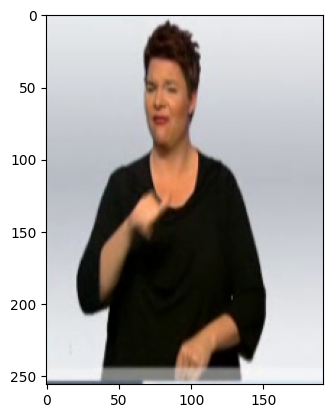

In [407]:
B, T, C, H, W = x.shape
x = rearrange(
    transform(rearrange(x, "b t c h w -> (b t) c h w")),
    "(b t) c h w -> b t c h w",
    b=B,
    t=T,
)

# visualize the first frame

import matplotlib.pyplot as plt

frame = x[0, 75].permute(1, 2, 0).numpy()

plt.imshow(frame)

In [425]:
out = model(x)

In [409]:
out.argmax(-1)

tensor([[ 855,  831, 1128, 1014,  294, 1146,  279,  941,   44,  604,  913,  932,
           51,   72,   51,  291, 1020, 1146,  977,  519,  460,  320,  198,   82,
          170,  680,  355,  880,    0,  529,  880,  179,   75,   88,  170,  406,
         1079,  372,   92,  528,   46,  780, 1044,  265, 1166, 1162,  226,  659,
           98,  198,  693,  327,  185,  460,  327,  226, 1193,  718,  770, 1142,
          287,  742,  343,  678,  240,  459,  194, 1198,  448,  363,  593,  698,
          295, 1070,  997, 1089,   24,  484,  855,  808,  198, 1172,  462,  544,
          958,  440,  482,  872,  852,  797, 1074,  941,  750,  334, 1011,  148,
          705,  965,   83,  221,  450,  514,  557,  789,   14,   48,  167, 1070,
          553,  636,  990,  482,  745,  948,  544,  716,  802,  544,  748,  574,
          862,  953,  168,  880,  508,  631,  924, 1166,  782,  965,  259,  993,
          553,  631,  769,  703,  343,  736,  802,  802,  305,  802,  305,  107,
          609,  402,  913,  

In [426]:
model.vocabulary.string_from_logits(out)

['ANGST WENIGER WERDEN WAS WEG BLATT RHEIN loc-FLAECHENDECKEND loc-NORD AUFEINANDERTREFFEN T NIEDERSACHSEN SIEBTE ARM ENGLAND SICHER SOMMER ENGLAND WIND-PLUSPLUS NIEDRIG loc-LAND-PLUSPLUS FREUNDLICH WAHRSCHEINLICH VORDERSCHEIBE HOLLAND WARNUNG SAMSTAG NAH SCHADEN HEILIGE DRAUSSEN FEBRUAR HALTEN KURZ DIENSTAG cl-NULL TAUEN KURZ BRUCKBERG BEWEGEN SPAET LOCKER NICHT-FUENF SCHULD ZWANZIG ENTSPANNT WO SCHWACH-PLUSPLUS METER loc-OSTBAYERN MITTE SCHRANK ZAHL DANACH OBER DAENEMARK NICHT-DEUTSCH DREI-MONATE ABWECHSELN EIFEL FEBRUAR NICHT-DEUTSCH loc-IRGENDWO ZUM-BEISPIEL NICHT-NOCH-NICHT UMKEHREN KURZ NACH-HAUSE FREIZEIT ERLEICHERT BERUHIGEN ABEND MITTWOCH GEWITTER-PLUSPLUS DOCH SUEDWESTRAUM KUESTE CHANCE-PLUSPLUS MINDESTENS WEHEN KALT-PLUSPLUS TRUEB VERSPAETET SCHLECHTER BEOBACHTEN MAERZ SPAZIEREN REKORD SCHLUSS BITTE STADT LAGE NICHT-DEUTSCH ERLEICHERT NICHT-FUENF loc-GRENZE GLEICH NICHT-NOCH-NICHT SCHLESWIG WOCHE EBEN ENDLICH WUERTTEMBERG AUFLOESEN FRUEHLING MIT PFLANZE TIEF HOEHER SONNE loc

In [360]:
from lightning.pytorch.utilities.model_summary import summarize
from lightning.fabric.utilities import measure_flops

In [420]:
def xxs_mvit(vocab):
    return MobileViT(
        dims=[64, 80, 96],
        conv_channels=[16, 16, 24, 24, 48, 48, 64, 64, 80, 80, 320],
        num_classes=len(vocab) + 1,  # +1 for the blank token
        vocabulary=vocab,
        expand_ratio=2,
        patch_size=(2, 2),
    )


def xs_mvit(vocab):
    return MobileViT(
        dims=[96, 120, 144],
        conv_channels=[16, 32, 48, 48, 64, 64, 80, 80, 96, 96, 384],
        num_classes=len(vocab) + 1,  # +1 for the blank token
        vocabulary=vocab,
        expand_ratio=4,
        patch_size=(4, 4),
    )


def s_mvit(vocab):
    return MobileViT(
        dims=[144, 192, 240],
        conv_channels=[16, 32, 64, 64, 96, 96, 128, 128, 160, 160, 640],
        num_classes=len(vocab) + 1,  # +1 for the blank token
        vocabulary=vocab,
        expand_ratio=4,
        patch_size=(8, 8),
    )

In [421]:
model = xxs_mvit(vocab)

In [422]:
summarize(model)

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | in_conv     | Conv2DBlock       | 464    | train
1 | mv2_blocks  | ModuleList        | 45.7 K | train
2 | mvit_blocks | ModuleList        | 1.1 M  | train
3 | final_pw    | Conv2DBlock       | 26.2 K | train
4 | pool        | AdaptiveAvgPool2d | 0      | train
5 | classifier  | Linear            | 394 K  | train
6 | criterion   | CTCLoss           | 0      | train
7 | wer         | WordErrorRate     | 0      | train
----------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.240     Total estimated model params size (MB)
292       Modules in train mode
0         Modules in eval mode

In [6]:
import gc

gc.collect()
torch.cuda.empty_cache()

X = torch.randn(1, 30, 3, 256, 192).to("cuda")
model(X).shape

torch.Size([1, 30, 10])

In [11]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [ ]:
# CIFAR-10 dataset
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
    ]
)

LFWPeople_trainval = torchvision.datasets.LFWPeople(
    root="./data", split="train", download=True, transform=transform
)
LFWPeople_test = torchvision.datasets.LFWPeople(
    root="./data", split="test", download=True, transform=transform
)

from torch.utils.data import DataLoader

train_size = int(0.8 * len(LFWPeople_trainval))
val_size = len(LFWPeople_trainval) - train_size


LFWPeople_train, LFWPeople_val = torch.utils.data.random_split(
    LFWPeople_trainval,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42),
)

Files already downloaded and verified
Files already downloaded and verified


In [26]:
import wandb

from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_api")

wandb.login(key=secret_value_0)

ModuleNotFoundError: No module named 'kaggle_secrets'

In [27]:
wandb.init(project="mobilevit")

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/accuracy,▁▁▁▁▁▁▁▁▁▁▁█▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███▁▁▁
train/f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,▅▆▅▅▅▅▆▆▆▅▄▄▄▃▆▅▆██▃▃█▅▆▄▂▁▄▅▆▇▆▄▁▄▅▃▃
train/precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
val/accuracy,▁
val/f1,▁
val/loss,▁
val/precision,▁


In [30]:
import lightning.pytorch as lp

# setup training and wandb

N_LABELS = len(LFWPeople_trainval.class_to_idx)
BATCH_SIZE = 4

wandb_logger = lp.loggers.WandbLogger()

model = xs_mvit(N_LABELS)


train_loader = DataLoader(
    LFWPeople_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=3
)
val_loader = DataLoader(
    LFWPeople_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=3
)
test_loader = DataLoader(LFWPeople_test, batch_size=BATCH_SIZE, shuffle=False)

trainer = pl.Trainer(
    max_epochs=10,
    accelerator="cuda",
    logger=wandb_logger,
    callbacks=[
        lp.callbacks.ModelCheckpoint(
            monitor="val/loss",
            filename="best_model",
            save_top_k=1,
            mode="min",
        ),
        lp.callbacks.EarlyStopping(
            monitor="val/ loss",
            patience=3,
            mode="min",
        ),
    ],
)

wandb_logger.watch(model, log_graph=False)

trainer.fit(model, train_loader, val_loader)

wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/dario/repos/lis-vit/.venv/lib/python3.11/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | in_conv     | Conv2DBlock       | 464    | train
1 | mv2_blocks  | ModuleList        | 183 K  | train
2 | mvit_blocks | ModuleList        | 2.2 M  | train
3 | final_pw    | Conv2DBlock       | 37.6 K | train
4 | pool        | AdaptiveAvgPool2d | 0      | train
5 | classifier  | Linear            | 2.2 M  | train
6 | criterion   | CrossEntropyLoss  | 0      | train
----------------------------------------------------------
4.6 M    

Epoch 0:   0%|          | 0/1905 [00:00<?, ?it/s]                          

W1203 16:17:08.996000 24231 torch/_dynamo/convert_frame.py:844] [24/8] torch._dynamo hit config.cache_size_limit (8)
W1203 16:17:08.996000 24231 torch/_dynamo/convert_frame.py:844] [24/8]    function: 'forward' (/tmp/ipykernel_24231/2669167420.py:64)
W1203 16:17:08.996000 24231 torch/_dynamo/convert_frame.py:844] [24/8]    last reason: 24/0: GLOBAL_STATE changed: grad_mode 
W1203 16:17:08.996000 24231 torch/_dynamo/convert_frame.py:844] [24/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W1203 16:17:08.996000 24231 torch/_dynamo/convert_frame.py:844] [24/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.


Epoch 0:   3%|▎         | 51/1905 [00:29<18:08,  1.70it/s, v_num=okbj, train/loss=8.670, train/accuracy=0.000, train/precision=0.000, train/recall=0.000, train/f1=0.000] 


Detected KeyboardInterrupt, attempting graceful shutdown ...


Epoch 0: 100%|██████████| 1905/1905 [3:12:36<00:00,  0.16it/s, v_num=52k4, train/loss=8.370, train/accuracy=0.000, train/precision=0.000, train/recall=0.000, train/f1=0.000, val/loss=8.380, val/accuracy=0.0373, val/precision=0.000, val/recall=0.000, val/f1=0.000]


/home/dario/repos/lis-vit/.venv/lib/python3.11/site-packages/wandb/sdk/wandb_run.py:2374: UserWarning: Run (ws4252k4) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stdout", data),
/home/dario/repos/lis-vit/.venv/lib/python3.11/site-packages/wandb/sdk/wandb_run.py:2374: UserWarning: Run (x47z66mn) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stdout", data),


NameError: name 'exit' is not defined

In [ ]:
# flush cuda cache
torch.cuda.empty_cache()


wandb.finish()

In [ ]:
from phoenix_datasets import PhoenixVideoTextDataset
import torch
from torch.utils.data import DataLoader

import os

curr_dir = os.getcwd()
datapath = "data/phoenix-2014.v3/phoenix2014-release/phoenix-2014-multisigner"
path = os.path.join(curr_dir, datapath)

dtrain = PhoenixVideoTextDataset(
    # your path to this folder, download it from official website first.
    root=path,
    split="train",
    p_drop=0.5,
    random_drop=True,
)


def collate_add_blank(base_collate, batch):

    batch = base_collate(batch)  # add one to all labels
    batch["text"] = [tens + 1 for tens in batch["text"]]
    batch = (
        torch.stack(batch["video"], 0),
        torch.stack(batch["text"], 0),
    )

    return batch


vocab = dtrain.vocab

print("Vocab", vocab)

collation = lambda x: collate_add_blank(dtrain.collate_fn, x)

dl = DataLoader(dtrain, collate_fn=collation, shuffle=True, batch_size=1)

for batch in dl:
    video, label = batch

    print(video.shape, label.shape)

    break

Vocab {'A': 0, 'AACHEN': 1, 'AB': 2, 'AB-JETZT': 3, 'AB-PLUSPLUS': 4, 'ABEND': 5, 'ABER': 6, 'ABFALLEN': 7, 'ABSCHIED': 8, 'ABSCHNITT': 9, 'ABSINKEN': 10, 'ABWECHSELN': 11, 'ACH': 12, 'ACHT': 13, 'ACHTE': 14, 'ACHTHUNDERT': 15, 'ACHTUNG': 16, 'ACHTZEHN': 17, 'ACHTZIG': 18, 'AEHNLCH': 19, 'AEHNLICH': 20, 'AENDERN': 21, 'AFRIKA': 22, 'AKTIV': 23, 'AKTUELL': 24, 'ALLE': 25, 'ALLGAEU': 26, 'ALLGEMEIN': 27, 'ALPEN': 28, 'ALPENRAND': 29, 'ALPENTAL': 30, 'ALS': 31, 'ALSO': 32, 'ALT': 33, 'AM': 34, 'AM-KUESTE': 35, 'AM-MEER': 36, 'AM-RAND': 37, 'AM-TAG': 38, 'AMERIKA': 39, 'AN': 40, 'ANDERE': 41, 'ANDERE-MOEGLICHKEIT': 42, 'ANDERS': 43, 'ANFANG': 44, 'ANGEMESSEN': 45, 'ANGENEHM': 46, 'ANGST': 47, 'ANHALT': 48, 'ANKOMMEN': 49, 'ANSAMMELN': 50, 'ANSCHAUEN': 51, 'APRIL': 52, 'ARM': 53, 'ATLANTIK': 54, 'AUCH': 55, 'AUCH-NICHT': 56, 'AUF': 57, 'AUF-JEDEN-FALL': 58, 'AUFBLUEHEN': 59, 'AUFEINANDERTREFFEN': 60, 'AUFFUELLEN': 61, 'AUFHEITERN': 62, 'AUFHOEREN': 63, 'AUFKLAREN': 64, 'AUFKOMMEN': 65, 'AUF

In [304]:
vocab_inv = {(v + 1): k for k, v in vocab.table.items()}
len(vocab_inv)

1231

In [338]:
CV = CustomVocab(vocab_inv)

In [306]:
" ".join(labels_to_text(label[0], vocab_inv))

'__OFF__ U UEBERFLUTUNG DANEBEN __EMOTION__ __EMOTION__ REGEN-PLUSPLUS MEINEN GEWESEN GEWESEN'

In [307]:
label[0]

tensor([1140,  946,  950,  168, 1138, 1138,  752,  549,  341,  341])

In [317]:
# get logits with 1.0 on each label for the first batch
logits = torch.zeros(2, len(label[0]), len(vocab_inv) + 1)

In [318]:
vocab_inv[399]

'HEUTE-ABEND'

In [323]:
# set logits to 1.0 for each label
logits[:, torch.arange(len(label[0])), label[0]] = 1.0

In [339]:
CV.string_from_logits(logits)

['__OFF__ U UEBERFLUTUNG DANEBEN __EMOTION__ REGEN-PLUSPLUS MEINEN GEWESEN',
 '__OFF__ U UEBERFLUTUNG DANEBEN __EMOTION__ REGEN-PLUSPLUS MEINEN GEWESEN']

In [244]:
torch.argmax(logits, dim=-1)

tensor([[1140,  946,  950,  168, 1138, 1138,  752,  549,  341,  341]])

In [245]:
" ".join(labels_to_text(torch.argmax(logits, dim=-1)[0], vocab_inv))

'__OFF__ U UEBERFLUTUNG DANEBEN __EMOTION__ __EMOTION__ REGEN-PLUSPLUS MEINEN GEWESEN GEWESEN'

In [246]:
from pyctcdecode import build_ctcdecoder

In [247]:
labels = list(CV.vocab.values())

In [248]:
decoder = build_ctcdecoder(labels)

Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?


In [249]:
len(labels)

1232

In [250]:
decoder.decode_beams(logits.squeeze(0).numpy())

[('__PU__UEBER-UNTERUEBERSCHWEMMUNGDARAUF__OFF__REGION-PLUSPLUSMERKENGEWITTER-PLUSPLUS',
  None,
  [('__PU__UEBER-UNTERUEBERSCHWEMMUNGDARAUF__OFF__REGION-PLUSPLUSMERKENGEWITTER-PLUSPLUS',
    (0, 10))],
  np.float32(0.0),
  np.float32(0.0))]